In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

In [2]:
all_df = pd.read_csv('zillow.csv')

# Descriptive Stats

In [3]:
# create df containing only houses
house_df = all_df[all_df['type']=='House']

In [4]:
# turn zip into encoded integer
values = house_df['zip']

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

ohe_zip = pd.Series(integer_encoded)
ohe_zip.index=house_df.index
house_df=pd.concat([house_df,ohe_zip],axis=1,ignore_index=True)
house_df.columns = ["address", "prices", "beds", "baths", "sq_feet", "type", "zip", 'ohe_zip']
house_df

,address,prices,beds,baths,sq_feet,type,zip,ohe_zip
0,1821 Schlimgen Ave Madison WI 53704,190.0,2,1,0.6,House,53704,4
4,3914 Cosgrove Dr Madison WI 53719,360.0,3,3,2.3,House,53719,13
5,637 Chatham Ter Madison WI 53711,565.0,4,4,2.4,House,53711,6
6,606 S Baldwin St Madison WI 53703,350.0,2,1,1.0,House,53703,3
7,4410 Wakefield St Madison WI 53711,370.0,3,1,1.4,House,53711,6
...,...,...,...,...,...,...,...,...
288,433 Warbler Ln Madison WI 53704,58.0,3,2,1.0,House,53704,4
289,115 N Paterson St Madison WI 53703,350.0,3,2,1.3,House,53703,3
290,208 Wind Stone Dr Madison WI 53718,295.0,3,3,1.5,House,53718,12
291,9421 Elderberry Rd Middleton WI 53562,525.0,4,3,2.6,House,53562,1


In [5]:
house_df.agg(
    {
    'prices': ['min', 'max', 'median', 'mean', 'skew'],
    'beds': ['min', 'max', 'median', 'mean', 'skew'],
    'baths': ['min', 'max', 'median', 'mean', 'skew'],
    'sq_feet': ['min', 'max', 'median', 'mean', 'skew']
    }
)

,prices,beds,baths,sq_feet
min,58.000000,2.000000,1.000000,0.600000
max,1395.000000,4.000000,4.000000,3.500000
median,340.000000,3.000000,2.000000,1.800000
mean,367.418719,3.182266,2.334975,1.833990
skew,2.896546,-0.177144,0.091916,0.488081


In [6]:
# rid of outliers
house_df = house_df[(np.abs(stats.zscore(house_df['sq_feet'])) < 3)]

In [7]:
avg_price_beds = house_df.groupby('beds')['prices'].mean()
avg_price_baths = house_df.groupby('baths')['prices'].mean()
avg_price_sq_feet = house_df.groupby('sq_feet')['prices'].mean()

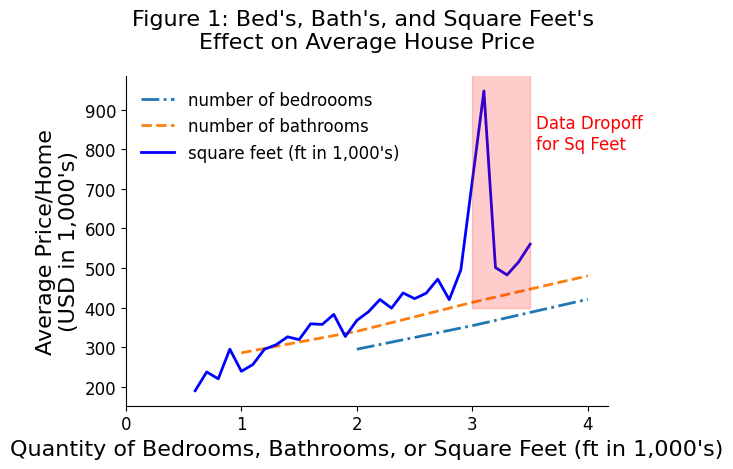

In [8]:
plt.style.use('default')

beds = avg_price_beds
baths = avg_price_baths
sq_feet = avg_price_sq_feet

fig, ax = plt.subplots() 
ax.plot(beds, 
        linestyle='-.', 
        linewidth=2,
        label="number of bedroooms")
ax.plot(baths, 
        linestyle='--',
        linewidth=2,
        label="number of bathrooms")
ax.plot(sq_feet, 
        linestyle='-', 
        linewidth=2,   
        color='blue',
        label="square feet (ft in 1,000\'s)")
ax.legend(frameon=False, fontsize=12)

ax.set_xlabel('Quantity of Bedrooms, Bathrooms, or Square Feet (ft in 1,000\'s)',  fontsize=16)
ax.set_ylabel('Average Price/Home\n(USD in 1,000\'s)', fontsize=16)
ax.set_title('Figure 1: Bed\'s, Bath\'s, and Square Feet\'s \nEffect on Average House Price', pad=20, fontsize=16)
ax.set_xticks(range(0,5))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)

ax.text(3.55, 800, "Data Dropoff \nfor Sq Feet", color="red", fontsize = 12)

# highlighted region indicating data drop off
#patch = plt.Rectangle((x,y), width, height)
patch = plt.Rectangle((3,400), 0.5, ax.get_ylim()[1],
                     color="red",
                     zorder=30, #high means it sits over other content, low mean it falls under other content
                     alpha=0.2) 
ax.add_artist(patch)

plt.tight_layout()

plt.show()

# Unsupervised ML

In [9]:
xcols = ["beds",'baths','sq_feet', 'ohe_zip']
ycol = "price"

In [10]:
def explained(scale):                            
    
    stages = [("imp", SimpleImputer(strategy="most_frequent"))]
    if scale:
        stages.append(("std", StandardScaler()))
    stages.append(("pca", PCA()))
    p = Pipeline(stages)
    p.fit(house_df[xcols])

    explained = p["pca"].explained_variance_
    s = pd.Series(explained.cumsum() / explained.sum(),
                  index=range(1, len(xcols)+1))
    print(s)
    return s

1    0.904237
2    0.976788
3    0.993580
4    1.000000
dtype: float64
1    0.555934
2    0.810724
3    0.940398
4    1.000000
dtype: float64


Text(0.5, 1.0, 'Figure 2: Principal Components of Madison Housing Prices')

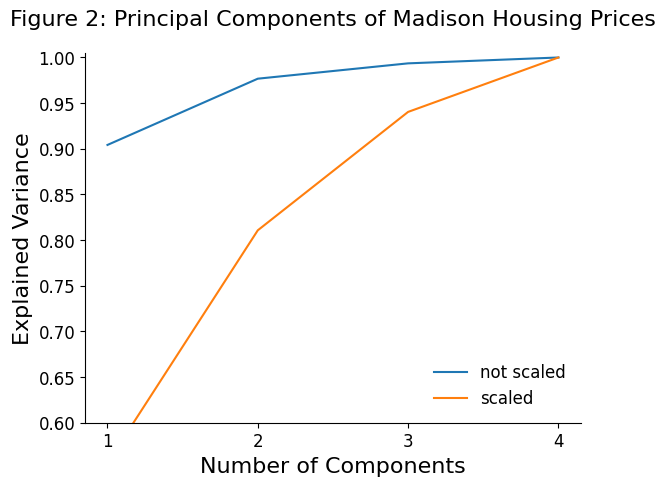

In [11]:
ax = explained(False).plot.line(label="not scaled", ylim=0.6)
explained(True).plot.line(label="scaled", ax=ax)
ax.set_xlabel("Number of Components",  fontsize=16)
ax.set_ylabel("Explained Variance",  fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(range(1,5))
ax.legend(frameon=False, fontsize=12)

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)

ax.set_title("Figure 2: Principal Components of Madison Housing Prices", pad=20,  fontsize=16)


# Supervised ML

In [28]:
train, test = train_test_split(house_df, random_state=0)

In [29]:
def do_eval(just_sq_feet = False, balanced=None):
    
    p1 = Pipeline([
    ("lr", LinearRegression()),
    ])
    
    p2 = Pipeline([
    ("transformers", make_column_transformer((PolynomialFeatures(),["beds",'baths','sq_feet', 'ohe_zip'])
                                            )),                                             
    ("lr", LinearRegression()),
    ])
    
    
    # Pick a pipeline
    p = p1
    
    if p in [p1,p2]:
        if just_sq_feet:
             xcols = ['sq_feet']
        else:
            xcols = ["beds",'baths','sq_feet', 'ohe_zip']
    else:
        xcols = ["beds",'baths','sq_feet',"zip"]
        
    ycol = "prices"
    
    p.fit(train[xcols], train['prices'])
    response = p.predict(test[xcols])
    print("explained_variance_score:",  explained_variance_score(test[ycol], p.predict(test[xcols])))
    print("max_error:",  max_error(test[ycol], p.predict(test[xcols])))
    print("mean_absolute_error:",  mean_absolute_error(test[ycol], p.predict(test[xcols])))
    print("mean_squared_error:",  mean_squared_error(test[ycol], p.predict(test[xcols])))
    print("r2_score:",  r2_score(test[ycol], p.predict(test[xcols])))
    return p
p = do_eval(just_sq_feet=True)
# p = do_eval()


explained_variance_score: 0.19791562161566767
max_error: 549.0986394233746
mean_absolute_error: 72.46637613270462
mean_squared_error: 12134.720729355458
r2_score: 0.1975744236895185


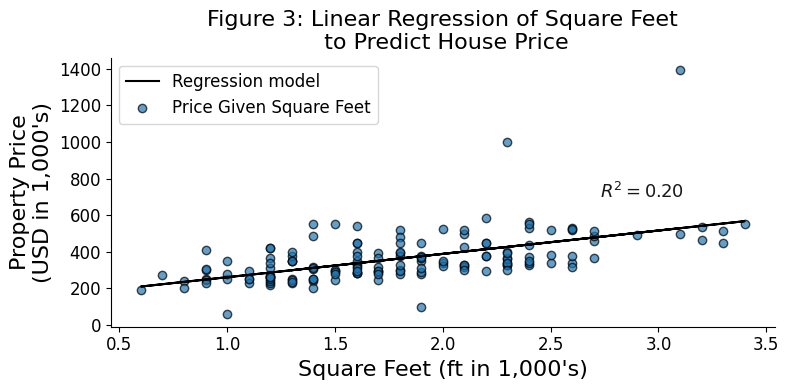

In [30]:
from sklearn import linear_model
p1 = Pipeline([
("lr", LinearRegression()),
])

x = train['sq_feet'].values.reshape(-1,1)
testx = test['sq_feet'].values.reshape(-1,1)
y = train['prices'].values
testy = test['prices'].values

model = p1.fit(x, y)
response = model.predict(x)

r2 = model.score(testx, testy)

# plt.style.use('default')
# plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(x, response, color='k', label='Regression model')
ax.scatter(x, y, edgecolor='k', alpha=0.7, label='Price Given Square Feet')
ax.set_ylabel('Property Price\n(USD in 1,000\'s)',fontsize=16)
ax.set_xlabel('Square Feet (ft in 1,000\'s)', fontsize=16)
ax.text(0.8, 0.5, '$R^2= %.2f$' % r2, fontsize=13, ha='center', va='center',
         transform=ax.transAxes, color='k', alpha=0.9)
ax.legend(facecolor='white', fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title('Figure 3: Linear Regression of Square Feet\n to Predict House Price', fontsize=16)

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)

fig.tight_layout()